***Note: Google Colab has been used to run the the file***

# WHY FAKE NEWS IS A PROBLEM?
**Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.**
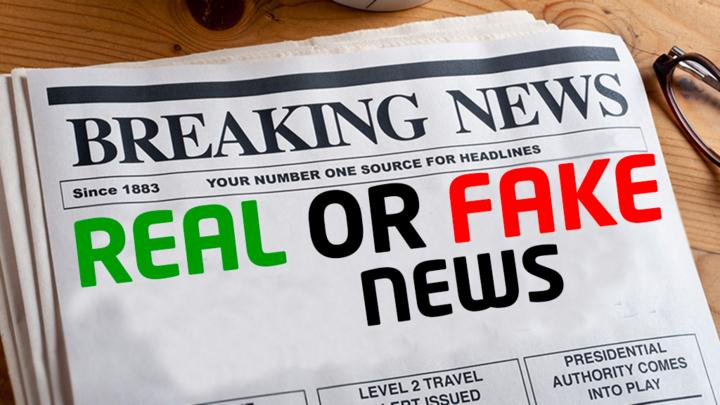

# Let's start!

The following code cell mounts Google Drive to access the dataset.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading 'stopwords' for removal of 'stopwords'
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## STEP 1: Import necessary libraries

In [ ]:
#!pip install tensorflow --upgrade --quiet
#!pip install wordcloud

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import warnings
from bs4 import MarkupResemblesLocatorWarning
warnings.filterwarnings('ignore', category=MarkupResemblesLocatorWarning)
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

## STEP 2: Load the dataset
- The dataset is stored in the Google Drive folder (news) with two files (True.csv & Fake.csv).

#### **BRIEF DESCRIPTION OF DATASET**
This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.


In [ ]:
# load the true news dataset
true = pd.read_csv("True.csv")

# load the fake news dataset
false = pd.read_csv("Fake.csv")

In [ ]:
#Print the first 5 rows of the dataset
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#print the first 5 rows of the dataset
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#Display information about the 'true' DataFrame
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
# Display information about the 'fake' DataFrame
false.info()

## STEP 3: Combine the datasets

In [ ]:
# Add a 'category' column to the 'true' DataFrame and assign the value 1.
true['category'] = 1

## Add a 'category' column to the 'false' DataFrame and assign the value 0.
false['category'] = 0

#concate the both datasets
df = pd.concat([true, false])

In [ ]:
#check null values
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
category,0


* There is no missing values in the dataset.

## STEP 4: Clean the data

In [ ]:
# This section focuses on cleaning the text data in the 'text' column of the 'df' DataFrame.

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)

    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)

## STEP 5: Word cloud for real and fake text


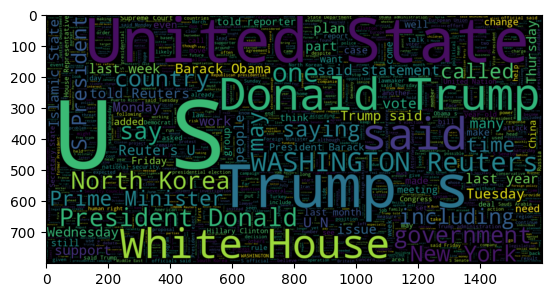

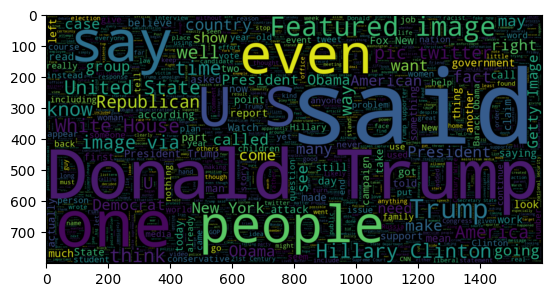

In [ ]:
# Word cloud for real and fake text
def plot_wordcloud(category):
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

# Plot word cloud for real text
plot_wordcloud(1)

# Plot word cloud for fake text
plot_wordcloud(0)


## STEP 6: Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

## STEP 7: Tokenizing text and padding sequences

In [ ]:
# Setting Hyperparameters
max_features = 10000
maxlen = 300
# Tokenization and Text-to-Sequence Conversion
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
#Preprocessing the Test Data
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

#Load Glove Embeddings

In [ ]:
# Load pre-trained GloVe embeddings to improve word representations in the model.
# GloVe website: nlp.stanford.edu/projects/glove/

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Step 11: Load pre-trained GloVe embeddings
EMBEDDING_FILE = '/content/drive/MyDrive/glove.twitter.27B.100d.txt'

def load_embeddings(embedding_file, word_index, max_features):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))
    all_embs = np.stack(list(embeddings_index.values())) # Stack all embeddings
    emb_mean, emb_std = all_embs.mean(), all_embs.std() # Calculate mean and standard deviation
    embed_size = all_embs.shape[1] # Get embedding size

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size

# Create the embedding matrix using the loaded embeddings, vocabulary, and feature size.
embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)

## STEP 8: Model definition and training

In [ ]:
# Define hyperparameters for training.
batch_size = 256 # No. of samples processed before the model is updated
epochs = 3 # No. of times the entire training dataset is passed through the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# Define the LSTM model architecture.
model = Sequential() # Create a sequential model
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
# Add an embedding layer using pre-trained GloVe embeddings (non-trainable)
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
# Add the first LSTM layer with 128 units, recurrent dropout, and dropout
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
# Add the second LSTM layer with 64 units, recurrent dropout, and dropout
model.add(Dense(units=32, activation='relu'))
# Add a dense layer with 32 units and ReLU activation
model.add(Dense(1, activation='sigmoid'))
# Add the output layer with sigmoid activation for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric

# Train the model using training data, validate with test data, and apply learning rate reduction
history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8105 - loss: 0.4015 - val_accuracy: 0.9465 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9467 - loss: 0.1463 - val_accuracy: 0.9800 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9687 - loss: 0.0921 - val_accuracy: 0.9891 - val_loss: 0.0363 - learning_rate: 0.0010


## STEP 9: Model evaluation and analysis

In [ ]:
print("Accuracy on Training Data:", model.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model.evaluate(x_test, y_test)[1] * 100, "%")

1053/1053 [==============================] - 183s 174ms/step - loss: 0.0560 - accuracy: 0.9824
Accuracy on Training Data: 98.23894500732422 %
351/351 [==============================] - 61s 174ms/step - loss: 0.0599 - accuracy: 0.9814
Accuracy on Testing Data: 98.1380820274353 %


#Plotting Training and Testing Accuracy & Loss Over Epochs

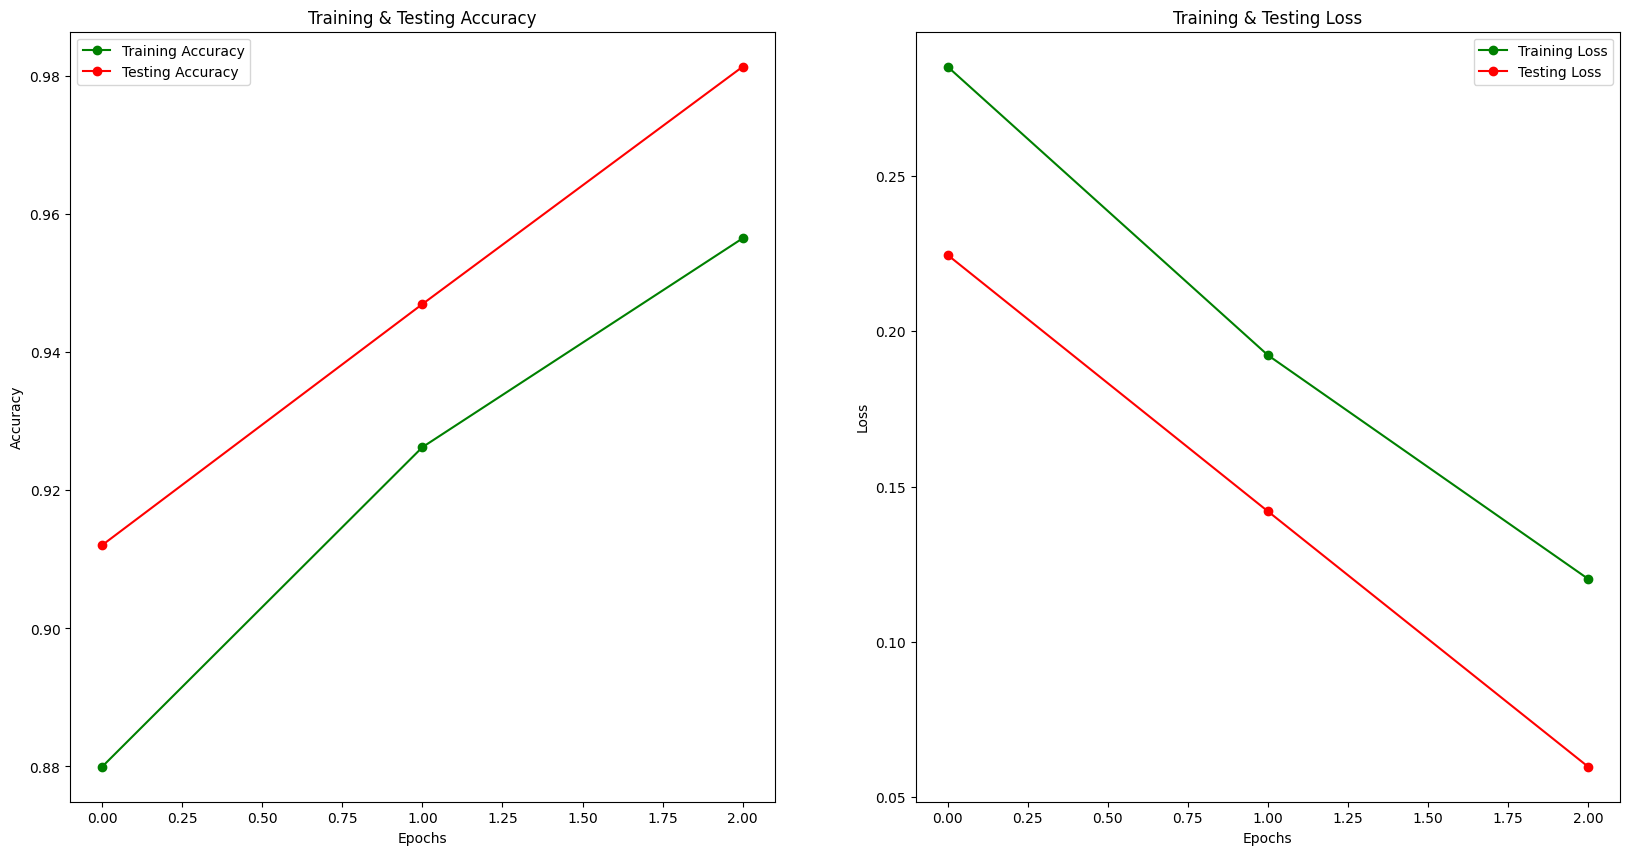

In [ ]:
# Get the actual number of epochs from the history object
actual_epochs = len(history.history['accuracy'])

epochs = [i for i in range(actual_epochs)]  # Adjust epochs array based on the actual number of epochs
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

Insight:


*   **Training and Testing Accuracy:**

1.   Steady increase over epochs.

2.   Converges around 90%, indicating effective learning and strong generalization to unseen data.



*   **Training and Testing Loss:**



1.   Continuous decrease over epochs.

2.   Converges to a low value, confirming the model’s ability to learn and generalize well.








## Step 10: Confusion Matrix and Classification Report

351/351 [==============================] - 61s 173ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      5858
    Not Fake       0.98      0.99      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



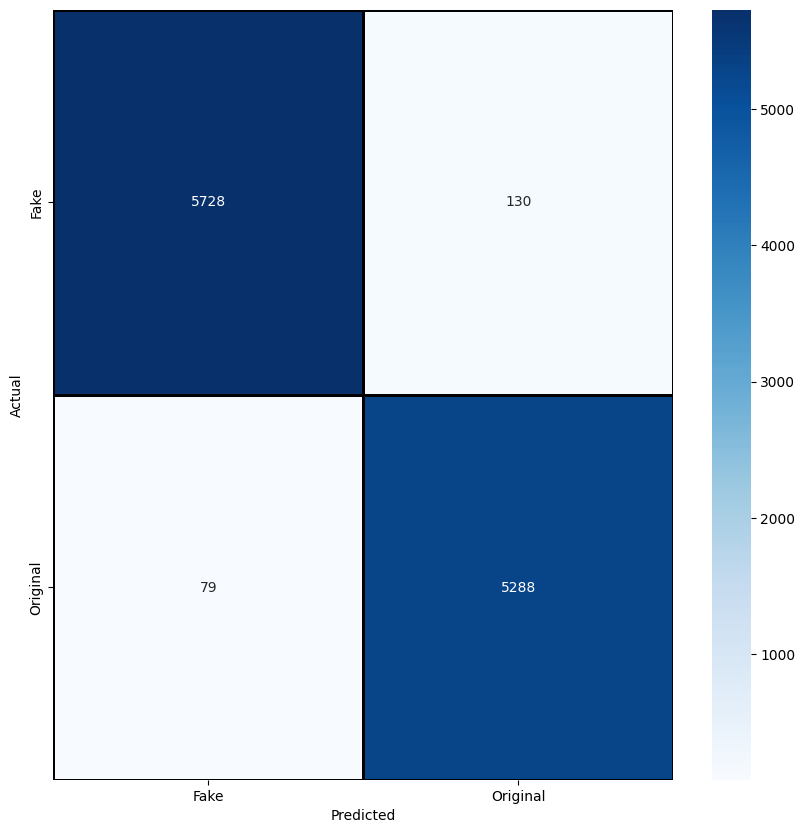

In [ ]:
# Use predict method to get predicted probabilities
pred_probabilities = model.predict(x_test)

# Threshold predicted probabilities to get predicted classes
pred = (pred_probabilities > 0.5).astype('int32')

print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=['Fake', 'Original'], columns=['Fake', 'Original'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Fake', 'Original'], yticklabels=['Fake', 'Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Conclusion:
This project focused on leveraging Natural Language Processing (NLP) to classify news articles as true or fake. By applying preprocessing techniques and machine learning models, we successfully trained a model to differentiate between authentic and fabricated news content.

# Key Findings:

 * **Model Accuracy**: The model demonstrated a strong ability to classify news articles, with promising results in distinguishing between true and fake news.
 * **Challenges**: Issues such as data imbalance and the subtle differences in language between real and fake news posed challenges, impacting model performance.
 * **Role of NLP**: NLP techniques proved essential in extracting key features from text, significantly aiding the classification process.

# Future Directions:

 * **Model Enhancement**: Implementing advanced models like BERT could further improve classification accuracy.
 * **Dataset Expansion**: Including a broader range of news sources would strengthen the model's generalization.
 * **Bias and Manipulation Detection**: Further research into identifying biased language or subtle manipulations could refine the model's ability to detect fake news.
This project highlights the potential of NLP in tackling misinformation and opens avenues for further advancements in automated news verification.

